# CNN ALLTOGETHER
### Putting everything together in one cell

In [ ]:
# Mount the Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


[0]
Epoch: 1
Epoch [1/10], Training Loss: 0.7991010572047944

Epoch [1/10], Validation Loss: 0.6961751133203506

Time elapsed for epoch 1: 312.71 seconds, or 5.21 minutes
Epoch: 2
Epoch [2/10], Training Loss: 0.6332239293037577

Epoch [2/10], Validation Loss: 0.7106504514813423

Time elapsed for epoch 2: 55.03 seconds, or 0.92 minutes
Epoch: 3
Epoch [3/10], Training Loss: 0.5926418355170716

Epoch [3/10], Validation Loss: 0.7184598073363304

Time elapsed for epoch 3: 53.50 seconds, or 0.89 minutes
Epoch: 4
Epoch [4/10], Training Loss: 0.537099431169794

Epoch [4/10], Validation Loss: 1.246845804154873

Time elapsed for epoch 4: 54.02 seconds, or 0.90 minutes
Epoch: 5
Epoch [5/10], Training Loss: 0.39071691194747354

Epoch [5/10], Validation Loss: 1.4429577514529228

Time elapsed for epoch 5: 53.49 seconds, or 0.89 minutes
Epoch: 6
Epoch [6/10], Training Loss: 0.3301270358422969

Epoch [6/10], Validation Loss: 1.697366639971733

Time elapsed for epoch 6: 55.02 seconds, or 0.92 minutes
E

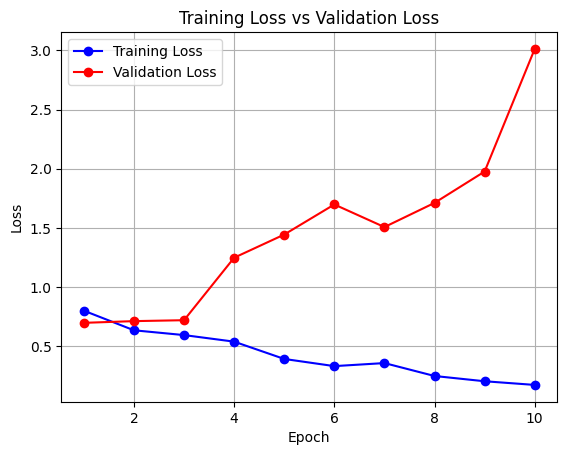

[1]
Epoch: 1
Epoch [1/10], Training Loss: 0.7989844971514762

Epoch [1/10], Validation Loss: 0.7321572080254555

Time elapsed for epoch 1: 53.87 seconds, or 0.90 minutes
Epoch: 2
Epoch [2/10], Training Loss: 0.6336607958408113

Epoch [2/10], Validation Loss: 0.7149919271469116

Time elapsed for epoch 2: 54.31 seconds, or 0.91 minutes
Epoch: 3
Epoch [3/10], Training Loss: 0.593105063793507

Epoch [3/10], Validation Loss: 0.8425543755292892

Time elapsed for epoch 3: 48.61 seconds, or 0.81 minutes
Epoch: 4
Epoch [4/10], Training Loss: 0.4487208296009835

Epoch [4/10], Validation Loss: 1.1309499368071556

Time elapsed for epoch 4: 56.87 seconds, or 0.95 minutes
Epoch: 5
Epoch [5/10], Training Loss: 0.30587845787088924

Epoch [5/10], Validation Loss: 1.9118441045284271

Time elapsed for epoch 5: 58.56 seconds, or 0.98 minutes
Epoch: 6
Epoch [6/10], Training Loss: 0.2914717326614451

Epoch [6/10], Validation Loss: 1.498315878212452

Time elapsed for epoch 6: 54.85 seconds, or 0.91 minutes
E

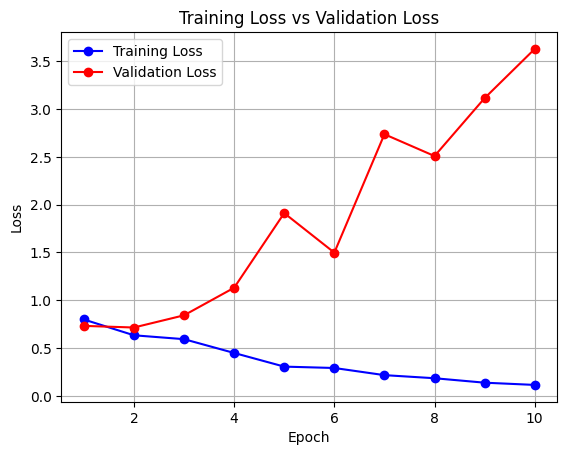

In [ ]:
#%% LIBRARIES #################################################################
import os
import random
import time
import numpy as np
from osgeo import gdal
import pandas as pd
from google.colab import drive
from PIL import Image
import tifffile as tiff
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.nn.functional import relu
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from datetime import datetime

#%% SEED ######################################################################
seed = 1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

#%% CNN CLASS #################################################################
class SimpleCNN(nn.Module):
  def __init__(self, num_classes, band):
      super(SimpleCNN, self).__init__()
      # Convolutional layers
      self.conv1 = nn.Conv2d(in_channels=band, out_channels=16, kernel_size=3, stride=1, padding=1)
      self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
      # Max pooling layers
      self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
      # Fully connected layers
      self.fc1 = nn.Linear(131072, 128)  # Assuming input image size is 128x128
      self.fc2 = nn.Linear(128, num_classes)  # Output layer
  def forward(self, x):
      #print('forward pass started')
      x = self.pool(nn.functional.relu(self.conv1(x)))
      #print('conv1 done')
      x = self.pool(nn.functional.relu(self.conv2(x)))
      #print('conv2 done')
      x = x.reshape(x.size(0), -1)
      #print('reshape done')
      #print(x.size())
      x = nn.functional.relu(self.fc1(x))
      x = self.fc2(x)
      return x

#%% DATASET CLASS ##############################################################
class CustomDataset(Dataset):
  def __init__(self, csv_file, Data_Folder, transform = None, datasplit = None, bands = None):
    self.data = pd.read_csv(csv_file, sep = ";", skiprows=None)
    if datasplit:
      self.data = self.data[self.data["datasplit"] == datasplit]
    self.data = self.data.reset_index(drop=True, inplace=False)
    self.image_paths = self.data['file']
    self.image_folder = Data_Folder
    self.target_values = self.data['label']
    self.transform = transform
    self.bands = bands
  def __len__(self):
    return len(self.image_paths)
  def __getitem__(self, idx):
    #print("Accessing item at index:", idx)
    #construct image path by joining folder path and image name
    image_name = self.image_paths[idx]
    image_path = os.path.join(self.image_folder, image_name)
    #open image using PIL
    #image = tiff.imread(image_path)
    image = tiff.imread(image_path)[:, :, self.bands]
    if self.transform:
      image = self.transform(image)
    #Mohamed's normalization method
    image= image[:,:,:]/10000
    image = image.astype('float32')
    image = torch.from_numpy(image)
    #get the labels
    label = int(self.target_values[idx])
    #print('Labels 1:', label)
    label = np.array(label).astype('float32')
    #print('Labels 2:', label)
    label = torch.tensor(label, dtype=torch.long)  # Convert label to a tensor
    #print('Labels 3:', label)
    return image, label

# Set file directory of the location where the data is stored
Data_Folder = "/content/drive/MyDrive/Master's Thesis/DATA/dataset_10bands_inc"
csv_file = "/content/drive/MyDrive/Master's Thesis/DATA/new_dataset_s2.csv"
log_file_path = "/content/drive/MyDrive/Master's Thesis/DATA/results/experiment_log.txt"



bands = [[0],[1],[2],[3],[4],[5],[6],[7],[8],[9]]

for band in bands:
    print(band)

    #%% INITIATE DATASETS ###################################################################
    train_dataset = CustomDataset(csv_file, Data_Folder, transform=None, datasplit="train", bands=band)
    test_dataset = CustomDataset(csv_file, Data_Folder, transform=None, datasplit="test", bands=band)
    validation_dataset = CustomDataset(csv_file, Data_Folder, transform=None, datasplit="val", bands=band)

    #%% CREATE MODEL & LOSS & OPTIMIZER ###################################################################
    # Set seed for Model Initialization
    torch.manual_seed(seed)
    # Create the instance of our Network
    model = SimpleCNN(4, len(band))
    # Define loss function (e.g., Cross-Entropy Loss for segmentation)
    loss_fn = nn.CrossEntropyLoss()
    # Define optimizer (e.g., Adam optimizer)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    #%% SETTING SEED, BATCH_SIZE, DATALOADER ###################################################################
    # Set seed for DataLoader (if using shuffle)
    torch.manual_seed(seed)
    # Data Loader Creation
    batch_size = 16
    # Current Version: only load "train" in the data loader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    #%% TRAINING LOOP ###################################################################

    # Empty list to store loss values for visualization
    train_loss_values = []
    val_loss_values = []
    test_loss_values = []

    # Create a text file to save the parameters and loss
    log_file = open(log_file_path, "a")  # "a" mode appends to the file
    log_file.write(f"********************************************************\n")
    current_datetime = datetime.now()
    log_file.write(f"EXPERIMENT OF: {current_datetime}\n")
    log_file.write(f"############\nNOTES:\nBAND(S) CONSIDERED: {band}\nSEED: {seed}\nLEARNINGRATE: {lr}\n")
    log_file.write(f"TRAINING\n")
    log_file.write(f"\n")


    #%% TRAINING ###################################################################
    torch.manual_seed(seed)
    num_epochs = 10
    for epoch in range(num_epochs):
        print("Epoch:", epoch+1)
        start_time = time.time()
        ############################# TRAINING STEP
        model.train()  # Set the model to training mode
        total_loss = 0
        for batch in train_loader:
            inputs, targets = batch
            inputs = inputs.permute(0, 3, 1, 2)
            # Forward pass
            outputs = model(inputs)
            # Compute loss
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Calculate the average loss for the epoch
        avg_loss = total_loss / len(train_loader)
        # Append the loss to the list
        train_loss_values.append(avg_loss)
        # Print average loss for the epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_loss}\n")
        # Save parameters and loss to the log file
        log_file.write(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_loss}\n")
        ############### VALIDATION STEP
        # Create a text file to save the parameters and loss
        log_file.write(f"-----------\n")
        log_file.write(f"EVALUATION\n")
        # Set seed for validation loop
        torch.manual_seed(seed)
        model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():  # Disable gradient calculation for validation
            for val_batch in val_loader:
                val_inputs, val_targets = val_batch
                val_inputs = val_inputs.permute(0, 3, 1, 2)
                # Forward pass for validation
                val_outputs = model(val_inputs)
                # Compute validation loss
                val_loss = loss_fn(val_outputs, val_targets)
                total_val_loss += val_loss.item()
        # Calculate and print average validation loss and accuracy
        avg_val_loss = total_val_loss / len(val_loader)
        val_loss_values.append(avg_val_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss}\n")
        # Print value in file
        log_file.write(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {avg_val_loss}\n")
        end_time = time.time()
        elapsed_time = end_time - start_time  # Calculate the elapsed time
        print(f"Time elapsed for epoch {epoch + 1}: {elapsed_time:.2f} seconds, or {elapsed_time/60:.2f} minutes")
    # Close the log file
    log_file.close()



    #%% TESTING ###################################################################

    # Create a text file to save the parameters and loss
    log_file_path = "/content/drive/MyDrive/Master's Thesis/DATA/results/experiment_log.txt"
    log_file = open(log_file_path, "a")  # "a" mode appends to the file
    log_file.write(f"__________________\n")
    log_file.write(f"TESTING\n")
    # Set seed for testing loop
    torch.manual_seed(seed)
    model.eval()  # Set the model to evaluation mode
    loss_values_test = 0.0
    correct = 0
    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in test_loader:
            images = images.permute(0, 3, 1, 2)
            # Forward pass
            outputs = model(images)
            # Calculate validation loss
            loss = loss_fn(outputs, labels)
            loss_values_test += loss.item()
            # Calculate the number of correct predictions
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
    # Calculate and print average validation loss and accuracy
    avg_test_loss = loss_values_test / len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset) * 100
    print(f'Testing Loss: {avg_test_loss:.4f}, Testing Accuracy: {accuracy:.2f}%')
    # Print value in the file
    log_file.write(f"Loss: {avg_test_loss}, Accuracy: {accuracy:.2f}\n")
    # Close the log file
    log_file.close()

    # PLOT #####################################################
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_loss_values, marker='o', linestyle='-', color='blue', label='Training Loss')
    plt.plot(range(1, num_epochs + 1), val_loss_values, marker='o', linestyle='-', color='red', label='Validation Loss')
    #plt.scatter(num_epochs + 1, avg_test_loss, color='green', label='Testing Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()